In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/My Drive/Colab Notebooks/Deep learning/LLaVa_food_grade_project'
%ls
import os
path = os.getcwd()
print('path: ' + path)
OutputPath = path + '/Output'
ModelPath = path + '/Models'
DataPath = path + '/Data'

/content/drive/My Drive/Colab Notebooks/Deep learning/LLaVa_food_grade_project
 Chat_GPT_rating_accuracy.ipynb   GPT2_prediction.ipynb   Output/
 CNN_rating_prediction.ipynb      LLaVa_Inference.ipynb   Prediction_with_CLIP.ipynb
 Data/                            Models/                'Score comparision.ipynb'
path: /content/drive/My Drive/Colab Notebooks/Deep learning/LLaVa_food_grade_project


In [4]:
import torch
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.metrics import accuracy_score

In [5]:
# Paths
llava_inference_image_only_path = OutputPath + '/llava_inference_images.csv'  # Inference file (images only)
llava_inference_text_image_path = OutputPath + '/llava_inference_text_images.csv'  # Inference file (text + images)
actual_scores_path = DataPath + '/reviews.csv'


# GPT2 tests

In [ ]:
# Change the model ID to GPT-2
model_id = "gpt2"

# Load the GPT-2 tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

# Add a pad token if it's missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Ensure model is on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# Function to generate predictions using LM
def predict_restaurant_score(model, tokenizer, inputs):
    inputs = tokenizer(inputs, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model.generate(**inputs, max_new_tokens=60)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the score (assuming the score is a number between 1-5 in the model's response)
    for word in prediction.split():
        if word.isdigit() and 1 <= int(word) <= 5:
            return int(word)
    return -1  # Return -1 for invalid prediction


In [ ]:
# Function to generate predictions using GPT-2 and extract the score
def predict_restaurant_score(model, tokenizer, inputs):
    # Prompt
    prompt = f"{inputs}\nRate the food quality from 1 to 5. Answer only with a number."

    tokenized_inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)

    # Limit the generation to a very short response, ideally 1 token or 2.
    outputs = model.generate(**tokenized_inputs, max_new_tokens=50, temperature=0.1, pad_token_id=tokenizer.eos_token_id)


    # Decode the generated output and extract prediction
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    # Debugging: Print the full prediction
    print(f"Full prediction: {prediction}")

    # Ensure the prediction is a valid number between 1 and 5
    if prediction.isdigit() and 1 <= int(prediction) <= 5:
        return int(prediction)

    # If no valid score is found, return -1 (invalid score)
    return -1


In [ ]:
# Load LLAVA inference data
llava_inference_images = pd.read_csv(llava_inference_image_only_path)
llava_inference_text_images = pd.read_csv(llava_inference_text_image_path)

In [6]:
# Load review data
df = pd.read_csv(DataPath + '/reviews.csv')
df_of_tastes = df[df['rating_category'] == 'taste'].copy()
df_of_tastes.reset_index(drop=True, inplace=True)

# Reset index to ensure 'index' column is available - old index was different
df_of_tastes.reset_index(inplace=True)

# Ensure 'index' exists in LLAVA inference files
llava_inference_images.reset_index(inplace=True)
llava_inference_text_images.reset_index(inplace=True)

# Merge LLAVA inference data with df_of_tastes based on the index
llava_inference_images = llava_inference_images.merge(df_of_tastes[['index', 'rating']], on='index', how='inner')
llava_inference_text_images = llava_inference_text_images.merge(df_of_tastes[['index', 'rating']], on='index', how='inner')


NameError: name 'llava_inference_images' is not defined

In [ ]:
# Debugging: Check number of rows after merging
print(f"Rows after merging images only: {llava_inference_images.shape[0]}")
print(f"Rows after merging text+images: {llava_inference_text_images.shape[0]}")

Rows after merging images only: 330
Rows after merging text+images: 330


In [ ]:
# Predict scores for image-only inferences
predicted_scores_images = []
for idx, row in llava_inference_images.iterrows():
    llava_output = row['description']  # LLAVA inference output for images only
    predicted_score = predict_restaurant_score(model, tokenizer, llava_output)
    predicted_scores_images.append(predicted_score)

    # Debugging: Print progress and prediction
    if idx < 5:  # Limit to a few rows to avoid too much output
        print(f"Row {idx}, LLAVA output: {llava_output}, Predicted score: {predicted_score}")


TypeError: The current model class (BertForSequenceClassification) is not compatible with `.generate()`, as it doesn't have a language model head. Please use one of the following classes instead: {'BertLMHeadModel'}

In [ ]:
# Predict scores for text and image inferences
predicted_scores_text_images = []
for idx, row in llava_inference_text_images.iterrows():
    llava_output = row['inference']  # LLAVA inference output for text + images
    predicted_score = predict_restaurant_score(model, tokenizer, llava_output)
    predicted_scores_text_images.append(predicted_score)

Full prediction: The image features a dining table with a variety of food items on it. There are two white plates, one placed closer to the left side of the table and the other towards the right side. The table also has a bowl, a cup, and a spoon. 

The food on the table consists of a soup, a meat dish, and a vegetable dish. The soup is placed in the center of the table, while the meat dish is located towards the right side of the table. The vegetable dish is situated on the left side of the table. 

The overall appeal of the dish is enhanced by the diverse selection of food items, which cater to different tastes and preferences. The presentation of the food is also visually appealing, with the various dishes arranged neatly on the table.
Rate the food quality from 1 to 5. Respond with a number betweeen 1 to 5.
Full prediction: The image features a dining table with two trays filled with a variety of food items. The trays are placed on a wooden table, and there are multiple bowls and c

In [ ]:
# Add predicted scores to the inference DataFrames
llava_inference_images['predicted_score'] = predicted_scores_images
llava_inference_text_images['predicted_score'] = predicted_scores_text_images


In [ ]:
# Calculate accuracy for image-only predictions
valid_image_scores = llava_inference_images[llava_inference_images['predicted_score'] != -1]
accuracy_images = accuracy_score(valid_image_scores['rating'], valid_image_scores['predicted_score'])
print(f"Accuracy for image-only predictions: {accuracy_images * 100:.2f}%")

Accuracy for image-only predictions: 66.67%


In [ ]:
# Calculate accuracy for text + image predictions
valid_text_image_scores = llava_inference_text_images[llava_inference_text_images['predicted_score'] != -1]
accuracy_text_images = accuracy_score(valid_text_image_scores['rating'], valid_text_image_scores['predicted_score'])
print(f"Accuracy for text + image predictions: {accuracy_text_images * 100:.2f}%")

Accuracy for text + image predictions: 50.00%


In [ ]:
# Save the results
valid_image_scores.to_csv(OutputPath + '/gpt2_predictions_images.csv', index=False)
valid_text_image_scores.to_csv(OutputPath + '/gpt2_predictions_text_images.csv', index=False)

# *BERT tests*

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load a pre-trained BERT model (5 output classes)
#model_id = "bert-base-uncased"
model_name = "transformersbook/bert-finetuned-amazon-reviews"
bert_model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=5)  # Adjust num_labels for ratings 1-5
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
bert_model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Prepare inputs from your dataset (assuming 'description' column)
def preprocess_texts(texts, tokenizer, max_length=128):
    inputs = tokenizer(texts, max_length=max_length, padding=True, truncation=True, return_tensors='pt')
    return inputs

# Example of preprocessing
llava_descriptions = llava_inference_images['description'].tolist()  # Example from image descriptions
inputs = preprocess_texts(llava_descriptions, tokenizer)
inputs = {key: value.to(device) for key, value in inputs.items()}  # Move to device


In [ ]:
# Pass inputs through the model
with torch.no_grad():
    outputs = model(**inputs)

# Predicted logits
logits = outputs.logits

# Convert logits to class labels (ordinal prediction)
predicted_ratings = torch.argmax(logits, dim=1) + 1  # BERT gives classes 0-4, adjust to 1-5 scale
predicted_ratings = predicted_ratings.cpu().numpy()


In [ ]:
# Add predicted scores to the inference DataFrame
llava_inference_images['predicted_score'] = predicted_ratings

# Save the results
llava_inference_images.to_csv(OutputPath + '/bert_predictions_images.csv', index=False)


In [ ]:
from sklearn.metrics import mean_absolute_error

true_ratings = llava_inference_images['rating'].tolist()
mae = mean_absolute_error(true_ratings, predicted_ratings)
print(f'MAE for predictions: {mae}')


MAE for predictions: 1.0575757575757576


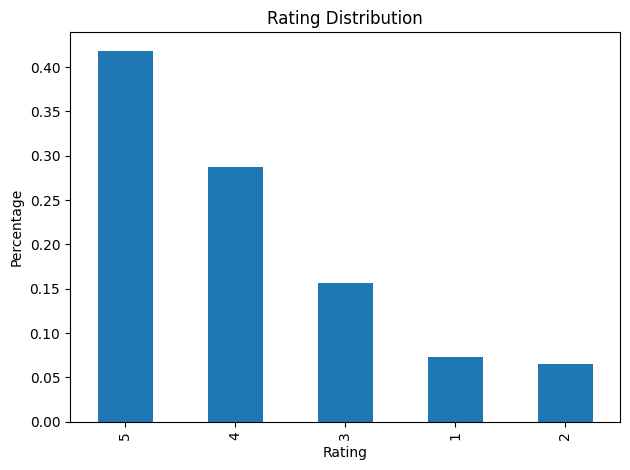

In [8]:
import matplotlib.pyplot as plt

df['rating'].value_counts(normalize=True).plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()